# Forest Fire Classification dataset

## Code

In [1]:
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from functools import partial
from sklearn import tree

## Sort data

In [4]:
#sort data

##day, month, year not necessary
forestfire_data = pd.read_csv("./Algerian Forest Fires/Algerian_forest_fires_dataset_UPDATE.csv", names=['day', 'month', 'year', 'Temperature',
                                                                                       'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC','ISI',
                                                                                       'BUI', 'FWI', 'Fire Status'])
##the first two rows are messed up when you load it, have to fix it.
forestfire_data = forestfire_data.drop([0,1])
forestfire_data
##remove day,month,year, as they provide nothing of relevance.
forestfire_data = forestfire_data.iloc[: , 3:]


#one problem with the data was that it was not properly sorted for the fire status.
print(forestfire_data['Fire Status'].unique())
#need to fix it by removing spaces.
forestfire_data['Fire Status'] = forestfire_data['Fire Status'].str.strip().str.lower()
forestfire_data = forestfire_data.dropna()
forestfire_data = forestfire_data[~forestfire_data['Fire Status'].isin(['classes'])]


##now, label fire as 1, not-fire as 0.
forestfire_data['Fire Status'] = forestfire_data['Fire Status'].replace({'not fire': 0, 'fire': 1})
pd.set_option('future.no_silent_downcasting', True)

##the last problem is that all of the numerical data is stored as objects
##convert back into respective int/float
forestfire_data['Temperature'] = forestfire_data['Temperature'].astype(int)
forestfire_data['RH'] = forestfire_data['RH'].astype(int)
forestfire_data['Ws'] = forestfire_data['Ws'].astype(int)
forestfire_data['Rain'] = forestfire_data['Rain'].astype(float)
forestfire_data['FFMC'] = forestfire_data['FFMC'].astype(float)
forestfire_data['DMC'] = forestfire_data['DMC'].astype(float)
forestfire_data['DC'] = forestfire_data['DC'].astype(float)
forestfire_data['ISI'] = forestfire_data['ISI'].astype(float)
forestfire_data['BUI'] = forestfire_data['BUI'].astype(float)
forestfire_data['FWI'] = forestfire_data['FWI'].astype(float)

forestfire_data.dtypes

['not fire   ' 'fire   ' 'fire' 'fire ' 'not fire' 'not fire ' nan
 'Classes  ' 'not fire     ' 'not fire    ']


Temperature      int32
RH               int32
Ws               int32
Rain           float64
FFMC           float64
DMC            float64
DC             float64
ISI            float64
BUI            float64
FWI            float64
Fire Status     object
dtype: object

## What the data looks like after cleaning

In [136]:
print(forestfire_data['Fire Status'].value_counts())
forestfire_data

Fire Status
1    137
0    106
Name: count, dtype: int64


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Fire Status
2,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0
3,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0
4,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
5,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0
6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...
243,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1
244,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0
245,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0
246,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0


In [137]:
#get X,Y for sake of training later.
XY = forestfire_data.values
X = XY[:,:-1]
y = XY[:,-1]
XY.shape




(243, 11)

## Partition data sets, visualize dataset partitions for sanity check!

In [138]:
#Data partitions (0.8/0.2 training-data, 0.5/0.5 training-to-data, 0.2/0.8 training-to-data)


#80-20 split
Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#50-50 split
Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#20-80 split
Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [158]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == 0).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1],
                c='blue', label='no fire')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1],
                c='red', label='fire')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

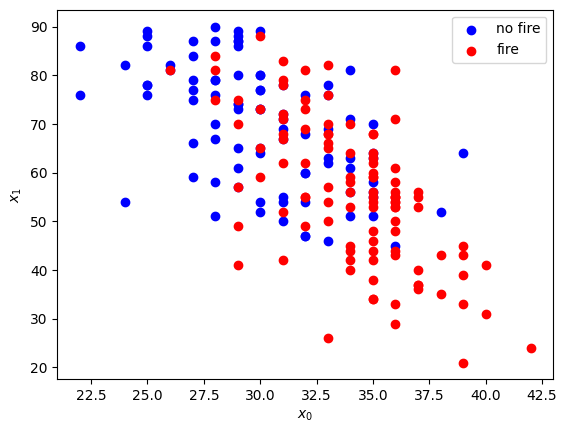

In [159]:
#more visualization
#Visualize training set as a sanity check; classes (0,1) are being plotted.
vis(Split1X_train, Split1y_train)

# Classifiers

## Partition: 80/20 set

Partition: 0.8
Train Accuracy: 0.9948453608247423
Validation Accuracy: 0.9692105263157895


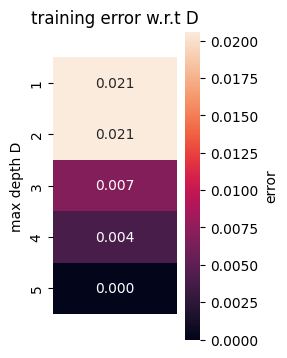

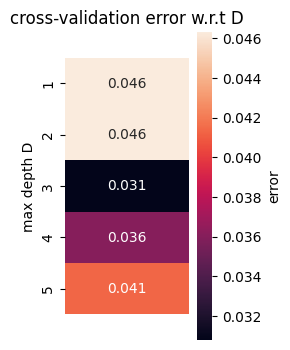

Best max depth D: 3
Test error: 0.020408163265306145
Train Accuracy: 0.9845360824742269
Validation Accuracy: 0.9692105263157893


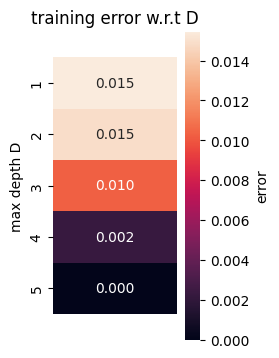

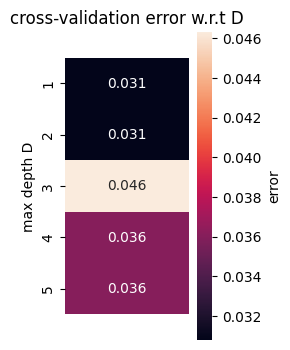

Best max depth D: 1
Test error: 0.020408163265306145
Train Accuracy: 1.0
Validation Accuracy: 0.9586842105263157


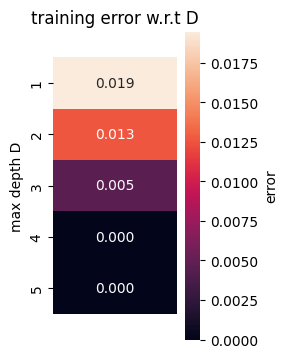

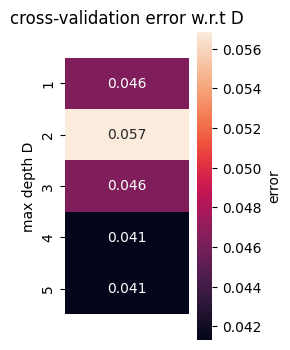

Best max depth D: 4
Test error: 0.020408163265306145


In [141]:
### Decision Tree ###
DTtestAccuracy_List1=[]
DTtestAccuracy_ListOverall = []
partitions = [0.8]
DTbest_max_depth_overall = 0
DT_best_accuracy = 0
trial = 3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split1X_train, Split1y_train)
        DTtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))


Partition: 0.8
Train Accuracy: 0.9845360824742269
Validation Accuracy: 0.9797368421052631


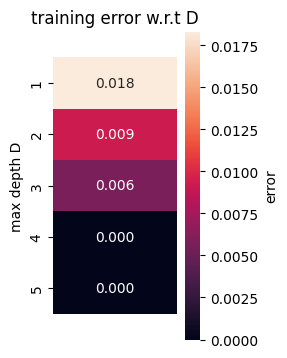

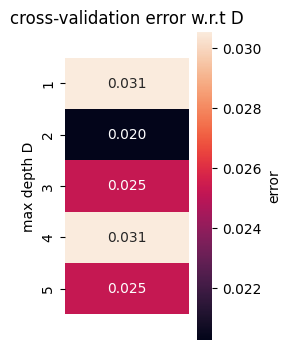

Best max depth D: 2
Test error: 0.020408163265306145
Train Accuracy: 0.9896907216494846
Validation Accuracy: 0.9797368421052631


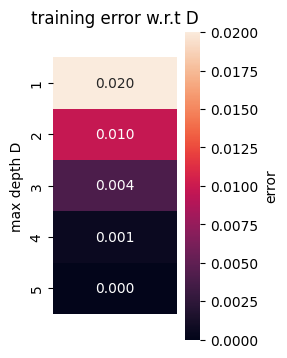

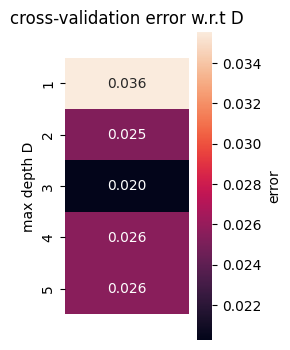

Best max depth D: 3
Test error: 0.020408163265306145
Train Accuracy: 0.9896907216494846
Validation Accuracy: 0.9797368421052631


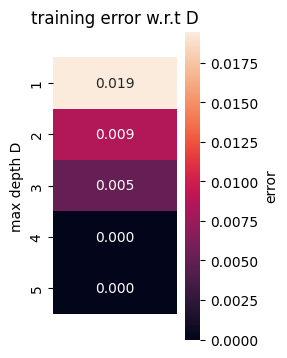

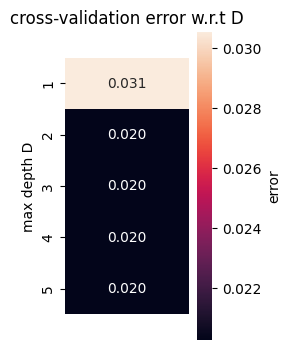

Best max depth D: 2
Test error: 0.020408163265306145


In [142]:
### Random Forests ###
RFtestAccuracy_List1=[]
RFtestAccuracy_ListOverall = []
partitions = [0.8]
RFbest_max_depth_overall = 0
RF_best_accuracy = 0
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split1X_train, Split1y_train)
        RFtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))
        

Partition: 0.8
Train Accuracy: 1.0
Validation Accuracy: 0.9897435897435898


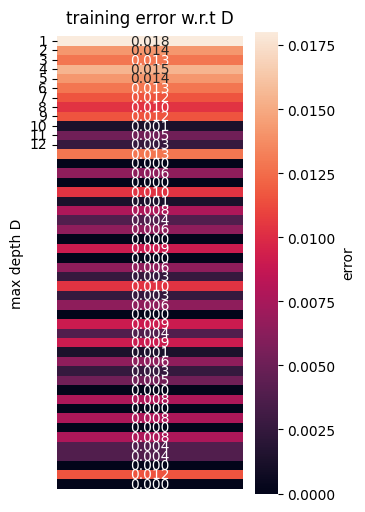

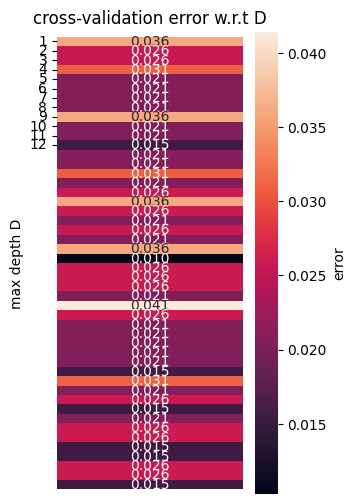

Best max depth D: 6
Test error: 0.020408163265306145
Train Accuracy: 0.9896907216494846
Validation Accuracy: 0.9846153846153847


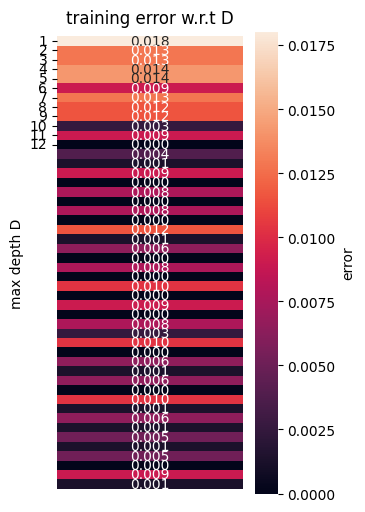

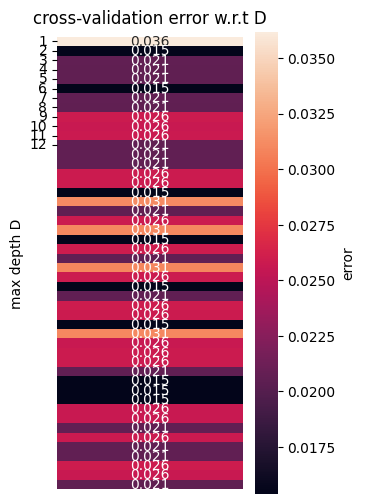

Best max depth D: 1
Test error: 0.0
Train Accuracy: 1.0
Validation Accuracy: 0.9897435897435898


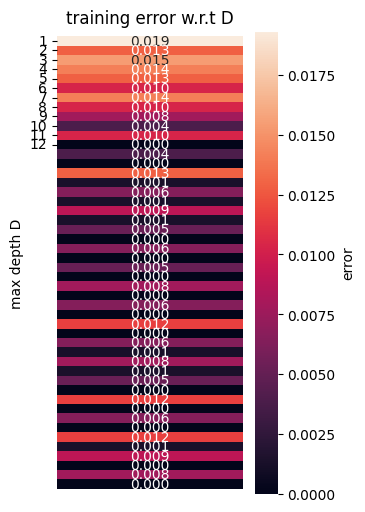

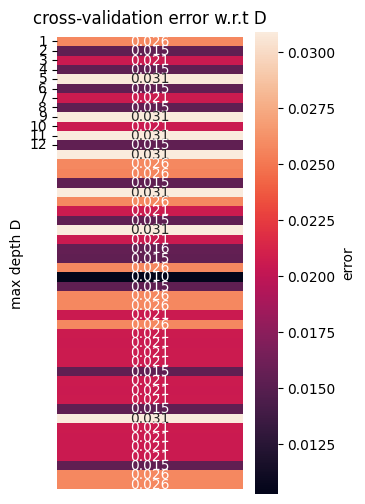

Best max depth D: 7
Test error: 0.020408163265306145


In [143]:
### Bagging family ###
BFtestAccuracy_List1=[]
BFtestAccuracy_ListOverall = []
partitions = [0.8]
BFbest_max_depth_overall = None
BF_best_accuracy = 0
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split1X_train, Split1y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split1X_test) == Split1y_test) / len(Split1X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split1X_train, Split1y_train)
        BFtestAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))

Partition: 0.8
Best C: 100, Best Gamma: 0.001
Train Accuracy: 1.0
Validation Accuracy: 0.93306342780027


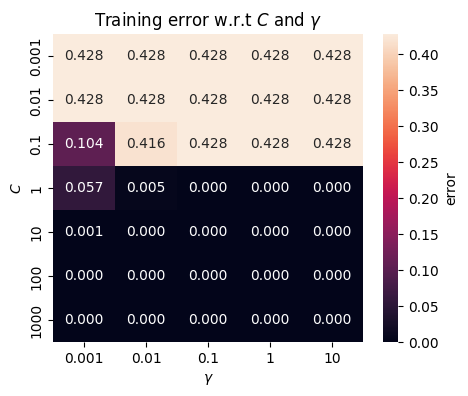

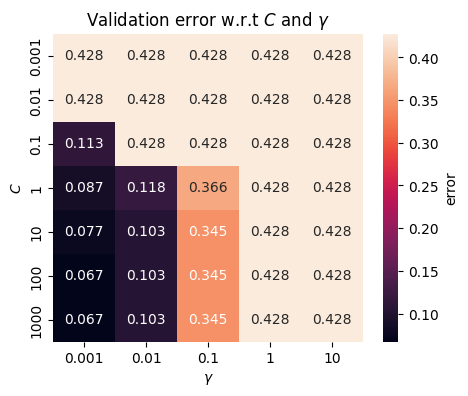

Best C: 100, Best Gamma: 0.001
Train Accuracy: 1.0
Validation Accuracy: 0.917408906882591


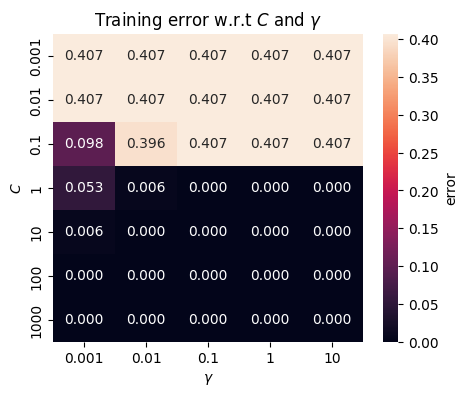

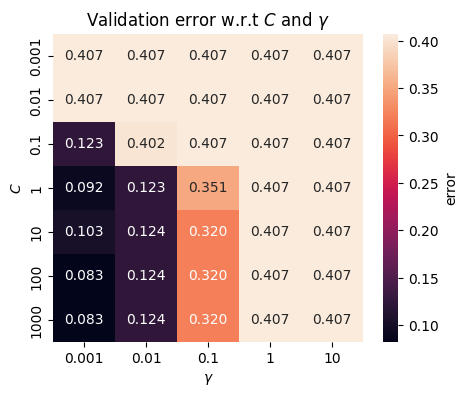

Best C: 100, Best Gamma: 0.001
Train Accuracy: 1.0
Validation Accuracy: 0.9588394062078273


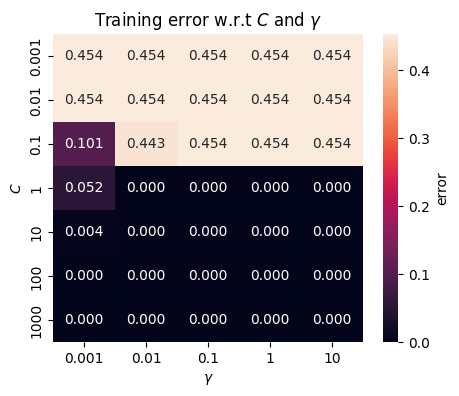

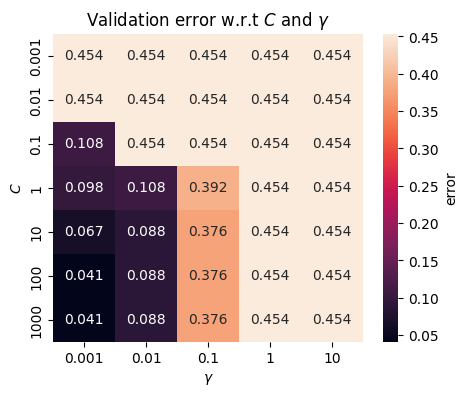

In [144]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.8]
trial = 3
testAccuracy_List1=[]
testAccuracy_ListOverall = []
training_errors = np.zeros((len(C_list), len(gamma_list)))
best_training_accuracy =0
best_C_overall = 0
best_gamma_overall = 0

#run 3 trials per partition
trial=3
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split1X_train, Split1X_test, Split1y_train, Split1y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split1X_train, Split1y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']


        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split1y_train, best_classifier.predict(Split1X_train))
        validation_accuracy = classifier_Search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma


        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
    
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split1X_train, Split1y_train)
        testAccuracy_List1.append(testClassifier.score(Split1X_test,Split1y_test))
        testAccuracy_ListOverall.append(testClassifier.score(Split1X_test,Split1y_test))




## Partition: 50/50 set

Partition: 0.5
Train Accuracy: 1.0
Validation Accuracy: 0.9666666666666666


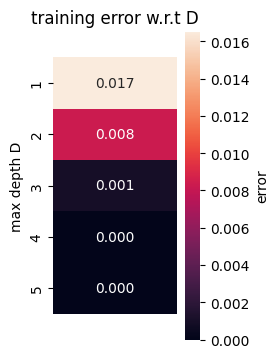

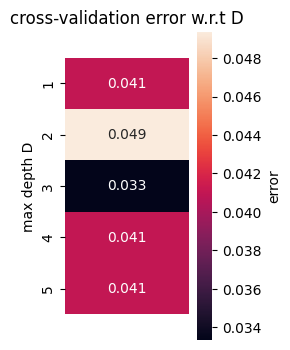

Best max depth D: 3
Test error: 0.049180327868852514
Train Accuracy: 0.9917355371900827
Validation Accuracy: 0.9756410256410255


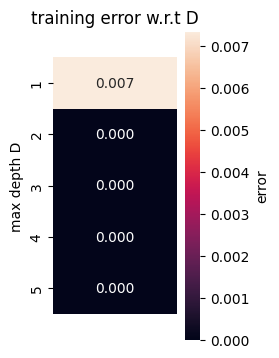

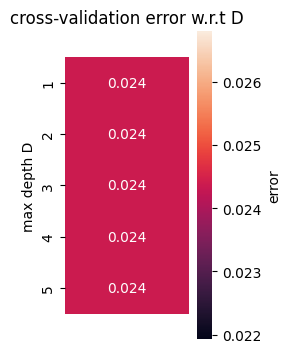

Best max depth D: 1
Test error: 0.032786885245901676
Train Accuracy: 1.0
Validation Accuracy: 0.975


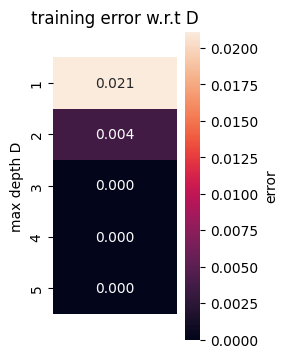

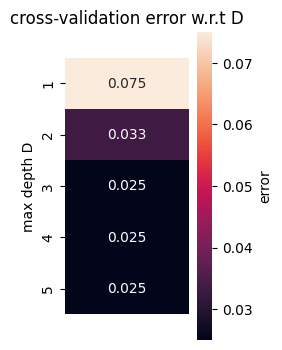

Best max depth D: 3
Test error: 0.016393442622950838


In [145]:
### Decision Tree ###
DTtestAccuracy_List2=[]
partitions = [0.5]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split2X_train, Split2y_train)
        DTtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))

Partition: 0.5
Train Accuracy: 0.9917355371900827
Validation Accuracy: 0.9756410256410255


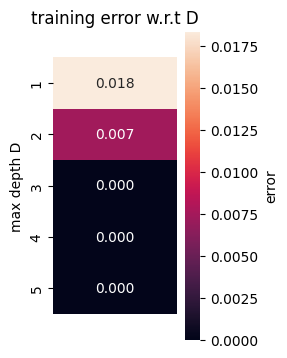

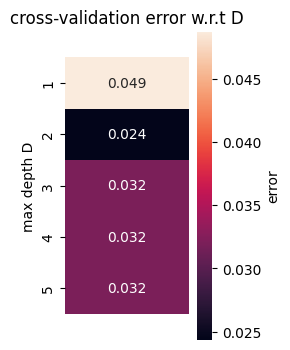

Best max depth D: 2
Test error: 0.016393442622950838
Train Accuracy: 1.0
Validation Accuracy: 0.9756410256410255


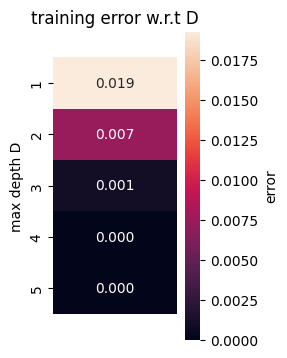

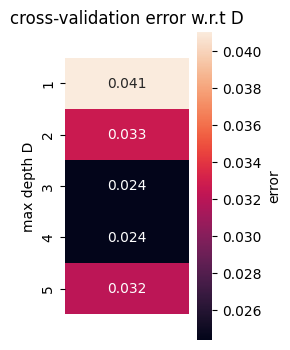

Best max depth D: 3
Test error: 0.016393442622950838
Train Accuracy: 1.0
Validation Accuracy: 0.9679487179487178


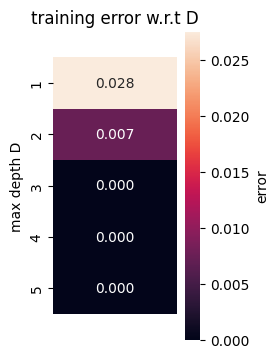

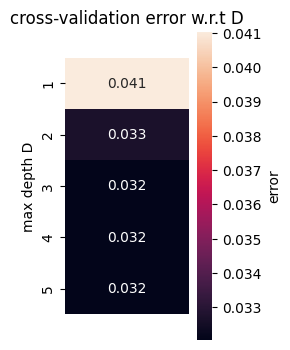

Best max depth D: 3
Test error: 0.016393442622950838


In [146]:
### Random Forests ###
RFtestAccuracy_List2=[]
partitions = [0.5]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split2X_train, Split2y_train)
        RFtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))
        

Partition: 0.5
Train Accuracy: 0.9917355371900827
Validation Accuracy: 0.9836666666666666


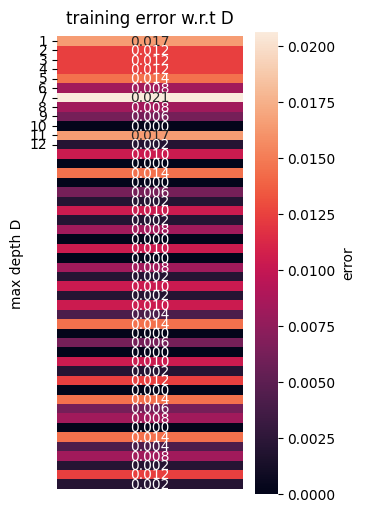

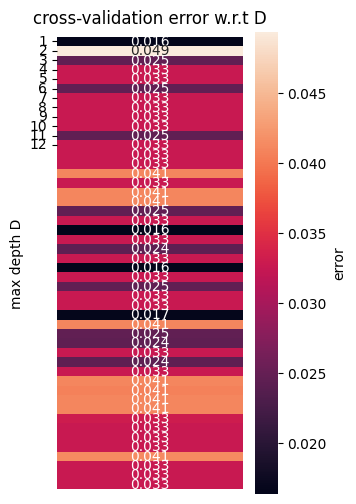

Best max depth D: 1
Test error: 0.008196721311475419
Train Accuracy: 1.0
Validation Accuracy: 0.9756666666666666


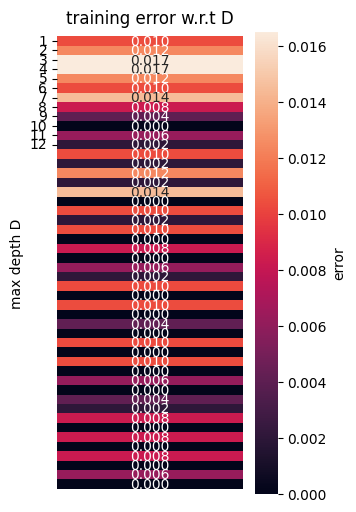

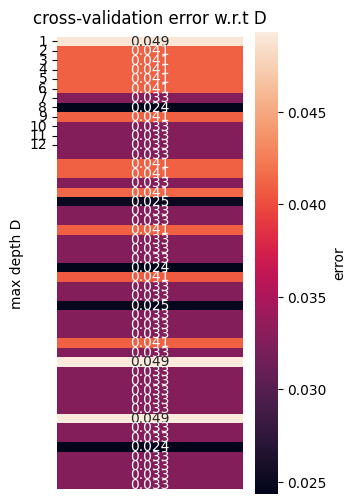

Best max depth D: 2
Test error: 0.024590163934426257
Train Accuracy: 0.9917355371900827
Validation Accuracy: 0.9756666666666666


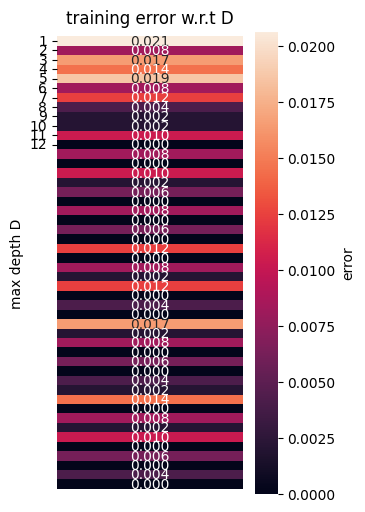

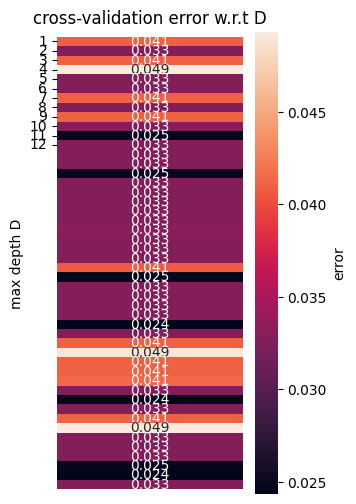

Best max depth D: 8
Test error: 0.008196721311475419


In [147]:
### Bagging family ###
BFtestAccuracy_List2=[]
partitions = [0.5]

for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split2X_train, Split2y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split2X_test) == Split2y_test) / len(Split2X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split2X_train, Split2y_train)
        BFtestAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))

Partition: 0.5
Best C: 10, Best Gamma: 0.001
Train Accuracy: 1.0
Validation Accuracy: 0.959


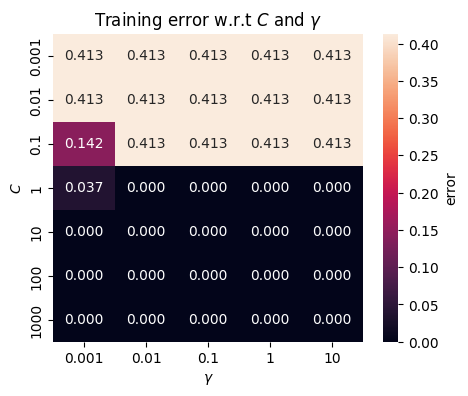

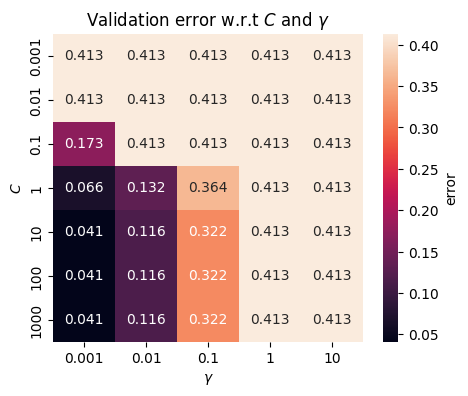

Best C: 100, Best Gamma: 0.001
Train Accuracy: 1.0
Validation Accuracy: 0.959


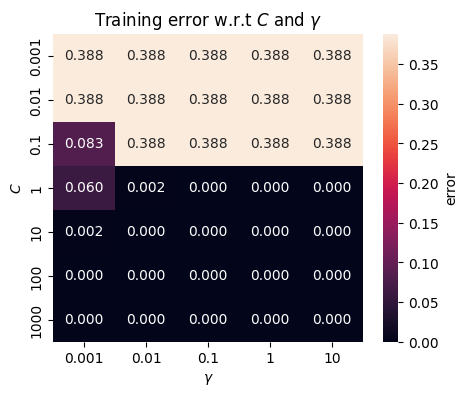

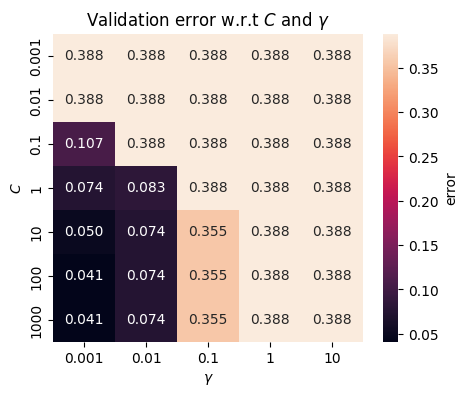

Best C: 100, Best Gamma: 0.001
Train Accuracy: 1.0
Validation Accuracy: 0.9586666666666668


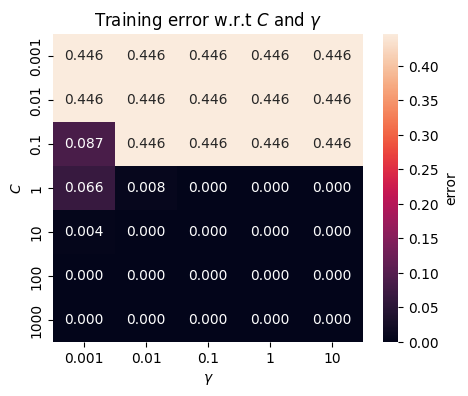

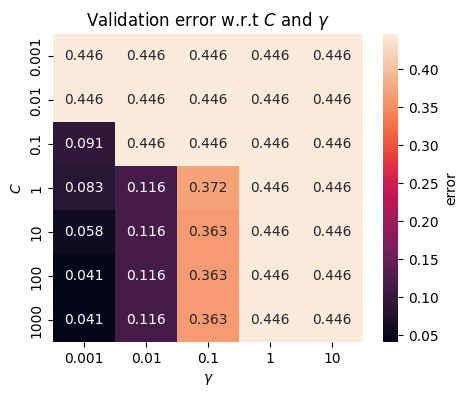

In [148]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.5]
trial = 3
testAccuracy_List2=[]
training_errors = np.zeros((len(C_list), len(gamma_list)))


#run 3 trials per partition
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split2X_train, Split2X_test, Split2y_train, Split2y_test = train_test_split(X, y, test_size=0.5, random_state=i)

        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split2X_train, Split2y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']

        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")


        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split2y_train, best_classifier.predict(Split2X_train))
        validation_accuracy = classifier_Search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')

        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma

        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        bestC= classifier_Search.best_params_['C']
        bestGamma= classifier_Search.best_params_['gamma']
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split2X_train, Split2y_train)
        testAccuracy_List2.append(testClassifier.score(Split2X_test,Split2y_test))
        testAccuracy_ListOverall.append(testClassifier.score(Split2X_test,Split2y_test))


## Partition: 20/80 set

Partition: 0.2
Train Accuracy: 1.0
Validation Accuracy: 0.9400000000000001


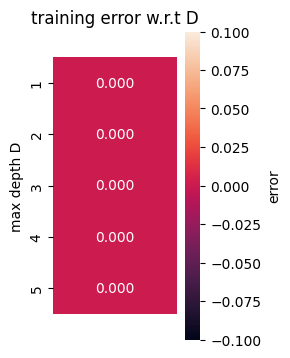

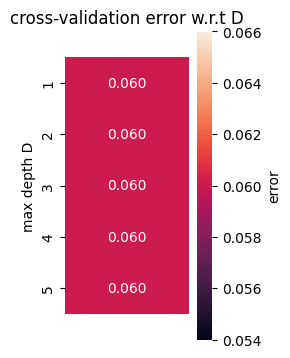

Best max depth D: 1
Test error: 0.03589743589743588
Train Accuracy: 1.0
Validation Accuracy: 0.9550000000000001


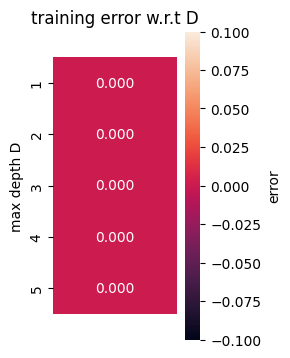

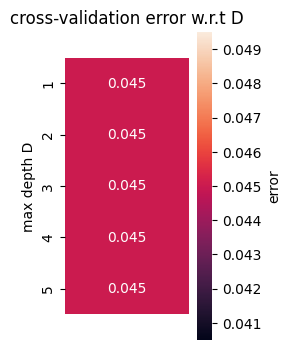

Best max depth D: 1
Test error: 0.02564102564102566
Train Accuracy: 0.9791666666666666
Validation Accuracy: 0.9349999999999999


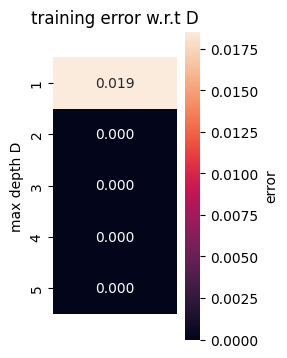

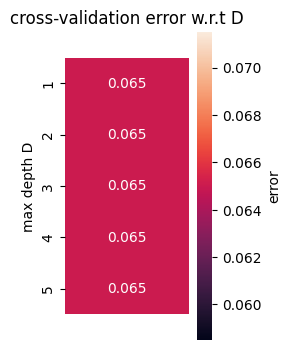

Best max depth D: 1
Test error: 0.01538461538461533


In [149]:
### Decision Tree ###
DTtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=i)
        estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > DT_best_accuracy:
            DT_best_accuracy = train_accuracy
            DTbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = DecisionTreeClassifier(max_depth=DTbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split3X_train, Split3y_train)
        DTtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        DTtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))

Partition: 0.2
Train Accuracy: 1.0
Validation Accuracy: 0.9800000000000001


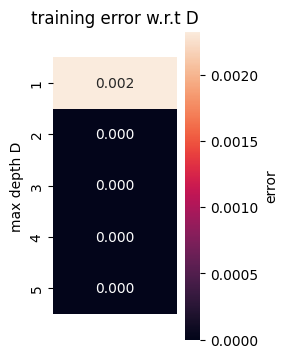

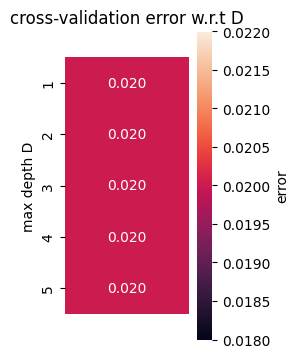

Best max depth D: 1
Test error: 0.0461538461538461
Train Accuracy: 1.0
Validation Accuracy: 0.9800000000000001


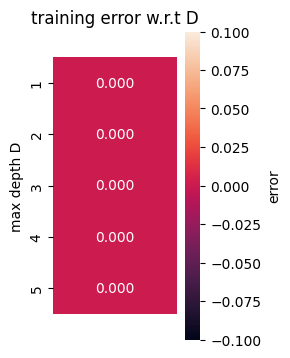

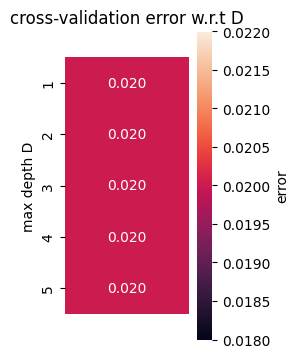

Best max depth D: 1
Test error: 0.03589743589743588
Train Accuracy: 1.0
Validation Accuracy: 0.9800000000000001


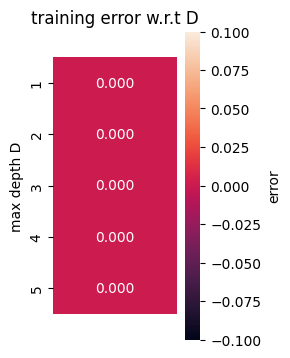

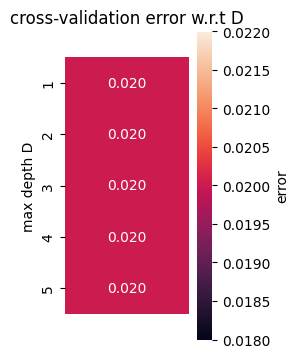

Best max depth D: 1
Test error: 0.03076923076923077


In [150]:
### Random Forests ###
RFtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)
        estimator = RandomForestClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5]
        param_grid = {'max_depth': D_list}
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator, param_grid, cv= cv, return_train_score=True)
        
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (2,4))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_params_['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > RF_best_accuracy:
            RF_best_accuracy = train_accuracy
            RFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = RandomForestClassifier(max_depth=RFbest_max_depth_overall, criterion="entropy")
        testClassifier.fit(Split3X_train, Split3y_train)
        RFtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        RFtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))
        

Partition: 0.2
Train Accuracy: 1.0
Validation Accuracy: 1.0


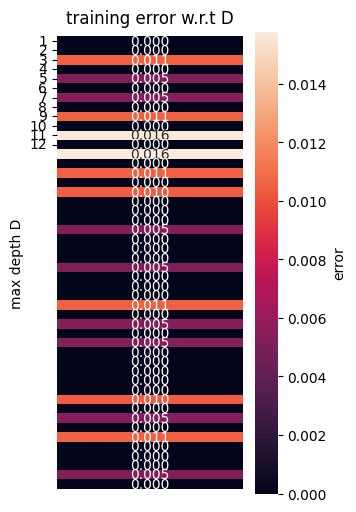

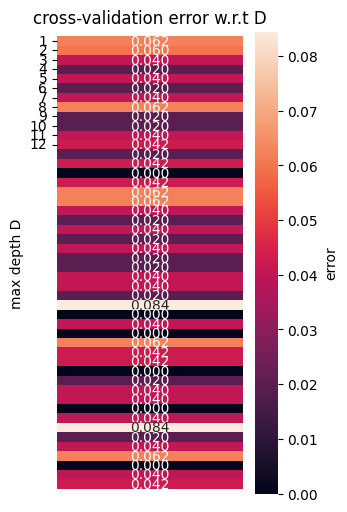

Best max depth D: 4
Test error: 0.03076923076923077
Train Accuracy: 1.0
Validation Accuracy: 1.0


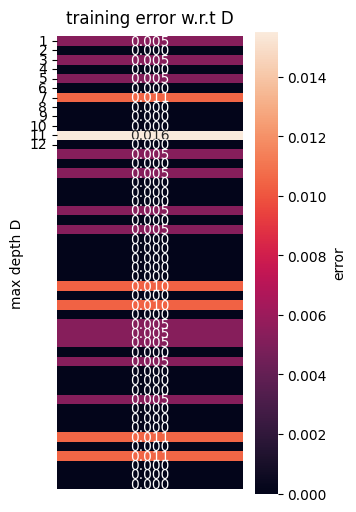

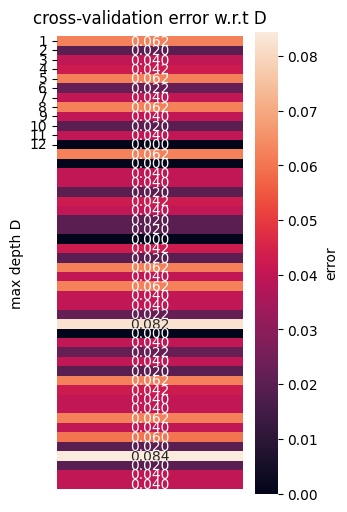

Best max depth D: 3
Test error: 0.02564102564102566
Train Accuracy: 1.0
Validation Accuracy: 1.0


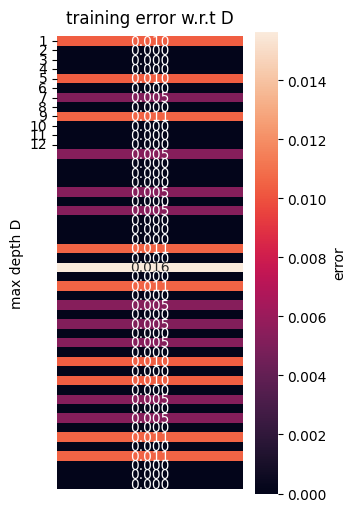

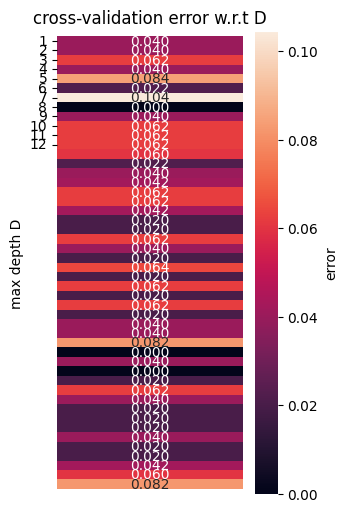

Best max depth D: 2
Test error: 0.03589743589743588


In [151]:
### Bagging family ###
BFtestAccuracy_List3=[]
partitions = [0.2]
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=42)
        estimator= tree.DecisionTreeClassifier(criterion='entropy', random_state=i)

        D_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        param_grid = {
        'estimator__max_depth': D_list,
        'n_estimators': [20],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
        }
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(BaggingClassifier(estimator=estimator), param_grid, cv=cv, return_train_score=True)
        grid_search.fit(Split3X_train, Split3y_train)
        best_classifier = grid_search.best_estimator_
        
        
        # Draw heatmaps for result of grid search.
        def draw_heatmap(errors, D_list, title):
            plt.figure(figsize = (3,6))
            ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
            ax.collections[0].colorbar.set_label('error')
            ax.set(ylabel='max depth D')
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            plt.title(title)
            plt.show()
    
        training_errors = 1 - grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = grid_search.best_score_

        
        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        
        draw_heatmap(training_errors, D_list, title='training error w.r.t D')
        draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
        
        best_max_depth = grid_search.best_estimator_.estimator.get_params()['max_depth']
        print("Best max depth D: {}".format(best_max_depth))
        if train_accuracy > BF_best_accuracy:
            BF_best_accuracy = train_accuracy
            BFbest_max_depth_overall = best_max_depth
        
        
        test_error = 1 - sum(grid_search.best_estimator_.predict(Split3X_test) == Split3y_test) / len(Split3X_test)
        print("Test error: {}".format(test_error))
        
        testClassifier = BaggingClassifier(DecisionTreeClassifier(max_depth=BFbest_max_depth_overall, criterion="entropy"))
        testClassifier.fit(Split2X_train, Split2y_train)
        BFtestAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))
        BFtestAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))

Partition: 0.2
Best C: 10, Best Gamma: 0.001
Train Accuracy: 1.0
Validation Accuracy: 0.9177777777777777


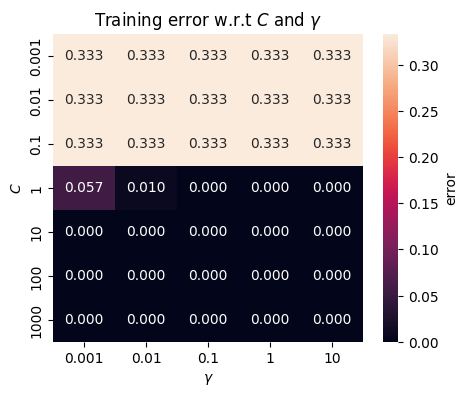

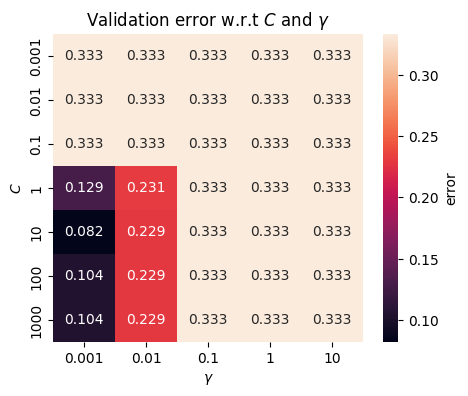

Best C: 1, Best Gamma: 0.001
Train Accuracy: 0.9583333333333334
Validation Accuracy: 0.9155555555555555


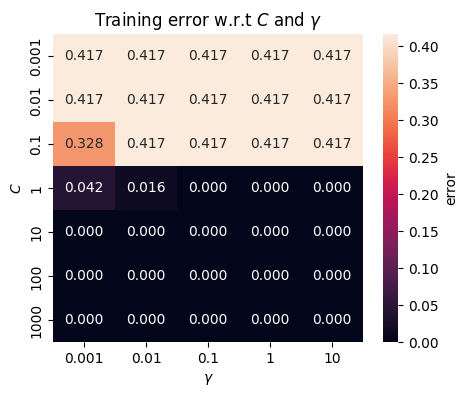

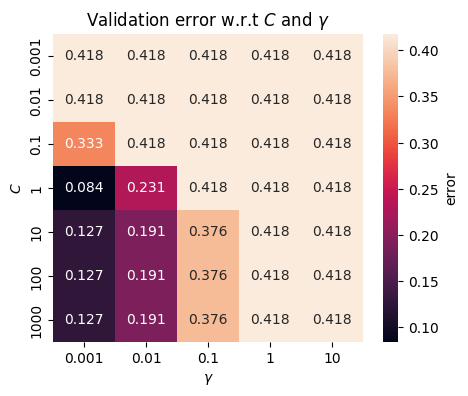

Best C: 0.1, Best Gamma: 0.001
Train Accuracy: 0.9166666666666666
Validation Accuracy: 0.9155555555555555


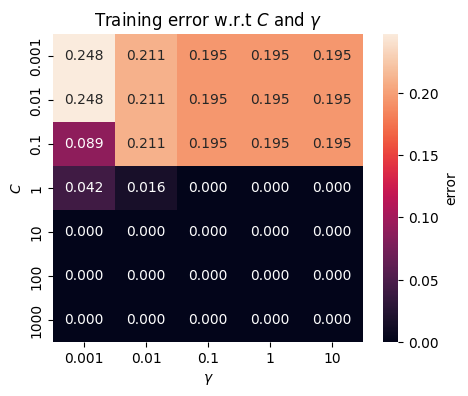

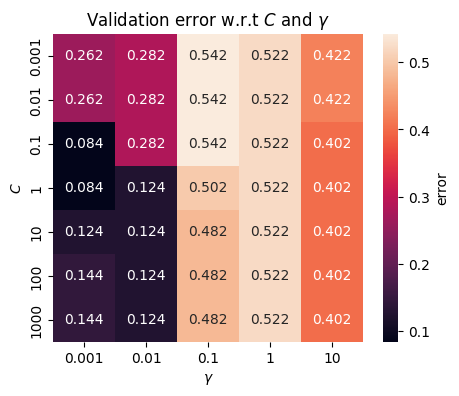

In [152]:
### SVM w/ RBF kernel ###
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)
    e = 1 - accuracy_score(Y, Y_pred)
    return e

# Draw heatmap function
def draw_heatmap(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Training error w.r.t $C$ and $\gamma$')
    plt.show()

def draw_heatmap2(training_errors, gamma_list, C_list):
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f',
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel=r'$\gamma$', ylabel=r'$C$')
    plt.title(r'Validation error w.r.t $C$ and $\gamma$')
    plt.show()

# Parameter grid for grid search
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
gamma_list = [1e-3, 1e-2, 1e-1, 1, 10]
param_grid = {'C': C_list, 'gamma': gamma_list}

# Data partition and number of trials
partitions = [0.2]
trial = 3
testAccuracy_List3=[]
training_errors = np.zeros((len(C_list), len(gamma_list)))


#run 3 trials per partition
for split in partitions:
    print(f'Partition: {split}')
    for i in range(trial):
        Split3X_train, Split3X_test, Split3y_train, Split3y_test = train_test_split(X, y, test_size=0.8, random_state=i)

        #find optimal hyperparameters
        classifier = SVC(random_state = i)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        classifier_Search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, return_train_score=True)
        classifier_Search.fit(Split3X_train, Split3y_train)

        best_classifier = classifier_Search.best_estimator_

        #this reports the best C, best gamma best on classifier_Search
        #use for best model to use on test data partitioned (i.e. 20, 50, 80 remaining splits).
        best_C = classifier_Search.best_params_['C']
        best_gamma = classifier_Search.best_params_['gamma']

        print(f"Best C: {best_C}, Best Gamma: {best_gamma}")

        # Calculate the training and validation accuracy
        train_accuracy = accuracy_score(Split3y_train, best_classifier.predict(Split3X_train))
        validation_accuracy = classifier_Search.best_score_


        print(f'Train Accuracy: {train_accuracy}')
        print(f'Validation Accuracy: {validation_accuracy}')
        if train_accuracy > best_training_accuracy:
            best_training_accuracy = train_accuracy
            best_C_overall = best_C
            best_gamma_overall = best_gamma

        training_errors = 1 - classifier_Search.cv_results_['mean_train_score']
        validation_errors = 1 - classifier_Search.cv_results_['mean_test_score']
        draw_heatmap(training_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        draw_heatmap2(validation_errors.reshape(len(C_list), len(gamma_list)), gamma_list, C_list)
        
        
        testClassifier = svm.SVC(C=best_C_overall, gamma=best_gamma_overall)
        testClassifier.fit(Split3X_train, Split3y_train)
        testAccuracy_ListOverall.append(testClassifier.score(Split3X_test,Split3y_test))
        testAccuracy_List3.append(testClassifier.score(Split3X_test,Split3y_test))


## Best training accuracy with optimal Hyperparameter

In [153]:
### Report best training accuracies with their optimal hyperparameters. ###
print(f'Best training accuracy for Decision Tree: {DT_best_accuracy} with optimal hyperparameter D:{DTbest_max_depth_overall}.')
print(f'Best training accuracy for Random Forests: {RF_best_accuracy} with optimal hyperparameter D:{RFbest_max_depth_overall}.')
print(f'Best training accuracy for Bagging family: {BF_best_accuracy} with optimal hyperparameter D:{BFbest_max_depth_overall}.')
print(f'Best training accuracy for SVM w/RBF: {best_training_accuracy} with optimal hyperparameter C:{best_C_overall} and gamma:{best_gamma_overall}')

Best training accuracy for Decision Tree: 1.0 with optimal hyperparameter D:4.
Best training accuracy for Random Forests: 1.0 with optimal hyperparameter D:3.
Best training accuracy for Bagging family: 1.0 with optimal hyperparameter D:6.
Best training accuracy for SVM w/RBF: 1.0 with optimal hyperparameter C:100 and gamma:0.001


## Report test data respective average accuracy.

In [154]:
### Decision Tree ###
print(f'The average of the test accuracies for Decision Tree is: {sum(DTtestAccuracy_ListOverall) / len(DTtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for  80/20 split Decision Tree is: {sum(DTtestAccuracy_List1) / len(DTtestAccuracy_List1)}')
print(f'The average of the test accuracies for  50/50 split Decision Tree is: {sum(DTtestAccuracy_List2) / len(DTtestAccuracy_List2)}')
print(f'The average of the test accuracies for  20/80 split Decision Tree is: {sum(DTtestAccuracy_List3) / len(DTtestAccuracy_List3)}')

The average of the test accuracies for Decision Tree is: 0.9755311736576373
The average of the test accuracies for  80/20 split Decision Tree is: 0.9863945578231292
The average of the test accuracies for  50/50 split Decision Tree is: 0.9726775956284154
The average of the test accuracies for  20/80 split Decision Tree is: 0.9675213675213675


In [155]:
### Random Forests ###
print(f'The average of the test accuracies for Random Forests is: {sum(RFtestAccuracy_ListOverall) / len(RFtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 Random Forests is: {sum(RFtestAccuracy_List1) / len(RFtestAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 Random Forests is: {sum(RFtestAccuracy_List2) / len(RFtestAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 Random Forests is: {sum(RFtestAccuracy_List3) / len(RFtestAccuracy_List3)}')

The average of the test accuracies for Random Forests is: 0.9797439614769825
The average of the test accuracies for 80/20 Random Forests is: 0.9863945578231292
The average of the test accuracies for 50/50 Random Forests is: 0.983606557377049
The average of the test accuracies for 20/80 Random Forests is: 0.9692307692307692


In [156]:
### Bagging family ### 
print(f'The average of the test accuracies for Bagging family is: {sum(BFtestAccuracy_ListOverall) / len(BFtestAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 Bagging family is: {sum(BFtestAccuracy_List1) / len(BFtestAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 Bagging family is: {sum(BFtestAccuracy_List2) / len(BFtestAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 Bagging family is: {sum(BFtestAccuracy_List3) / len(BFtestAccuracy_List3)}')

The average of the test accuracies for Bagging family is: 0.9904348232217086
The average of the test accuracies for 80/20 Bagging family is: 1.0
The average of the test accuracies for 50/50 Bagging family is: 0.9781420765027322
The average of the test accuracies for 20/80 Bagging family is: 0.9931623931623932


In [157]:
### SVM w/RBF kernel ###
print(f'The average of the test accuracies for SVM w/RBF is: {sum(testAccuracy_ListOverall) / len(testAccuracy_ListOverall)}')
print(f'The average of the test accuracies for 80/20 split SVM w/RBF is: {sum(testAccuracy_List1) / len(testAccuracy_List1)}')
print(f'The average of the test accuracies for 50/50 split SVM w/RBF is: {sum(testAccuracy_List2) / len(testAccuracy_List2)}')
print(f'The average of the test accuracies for 20/80 split SVM w/RBF is: {sum(testAccuracy_List3) / len(testAccuracy_List3)}')

The average of the test accuracies for SVM w/RBF is: 0.9377676361282918
The average of the test accuracies for 80/20 split SVM w/RBF is: 0.9523809523809524
The average of the test accuracies for 50/50 split SVM w/RBF is: 0.9344262295081966
The average of the test accuracies for 20/80 split SVM w/RBF is: 0.9264957264957264
